# Requirement Extraction from the Decision Tree

<div class="alert alert-info">
[Info]: This notebook does not contain any tasks for you, however, it can be usefull to get a better understanding of the 'get_all_input_specifications(...)' function, as well as the class-defintitions for 'Requirement' and 'InputSpecification'. You will need these to generate new input samples.
</div>
<hr/>

In this section, we will extract the learned features from the decision tree

In [1]:
from sklearn.feature_extraction import DictVectorizer
import pandas

# Features for each input, one dict per input
features = [
    {'function-sqrt': 1, 'function-cos': 0, 'function-sin': 0, 'number': -900},
    {'function-sqrt': 0, 'function-cos': 1, 'function-sin': 0, 'number': 300},
    {'function-sqrt': 1, 'function-cos': 0, 'function-sin': 0, 'number': -1},
    {'function-sqrt': 0, 'function-cos': 1, 'function-sin': 0, 'number': -10},
    {'function-sqrt': 0, 'function-cos': 0, 'function-sin': 1, 'number': 36},
    {'function-sqrt': 0, 'function-cos': 0, 'function-sin': 1, 'number': -58},
    {'function-sqrt': 1, 'function-cos': 0, 'function-sin': 0, 'number': 27},
]

# Labels for each input
oracle = [
    "BUG",
    "NO_BUG",
    "BUG",
    "NO_BUG",
    "NO_BUG",
    "NO_BUG",
    "NO_BUG"
]

# We can use the sklearn DictVectorizer to transform the features to numpy array:
# Notice: Use the correct labeling of the feature_names

# vec = DictVectorizer()
# X_vec = vec.fit_transform(features).toarray()
# feature_names = vec.get_feature_names_out()

# We can also use a pandas DataFrame and directly parse it to the decision tree learner
feature_names = ['function-sqrt', 'function-cos', 'function-sin', 'number']
X_data = pandas.DataFrame.from_records(features)

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Fix the random state to produce a deterministic result (for illustration purposes only)
clf = DecisionTreeClassifier(random_state=10)

# Train with DictVectorizer
# clf = clf.fit(X_vec, oracle)

# Train with Pandas Dataframe
clf = clf.fit(X_data, oracle)

import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_names,
                                class_names=["BUG", "NO BUG"],  
                                filled=True, rounded=True)  
graph = graphviz.Source(dot_data)  

<div class="alert alert-danger" role="alert">
Note: The sklearn DictVectorizer uses an internal sort function as default. This will result in different feature_name indices. If you want to use the Dictvectorizer please ensure that you only acess the feature_names with the function <i>vec.get_feature_names_out()</i>. We recommend that you use the pandas Dataframe, since this is also the format used in the feedback loop.
</div>

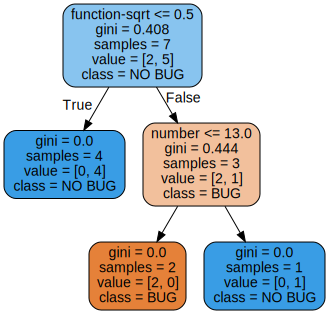

In [2]:
graph

In [3]:
from src.requirementExtractionDT.requirements import tree_to_paths

# We provide a functionallity to extract the paths from a decison tree.
all_paths = tree_to_paths(clf, feature_names)

# If you use the sklearn.DictVectorizer you have to use the feature_names extracted from the vectorizer,
# and invoke something similar to this:

# all_paths = tree_to_paths(clf, vec.get_feature_names_out())

#### Lets test wheather we extracted the correct paths

In [4]:
from typing import Tuple

# List[ ('Paths': str, Prediction_class: bool) ]
expected_paths = [('function-sqrt <= 0.5', False),
                  ('function-sqrt > 0.5 number <= 13.0', True),
                  ('function-sqrt > 0.5 number > 13.0', False)]

for count, path in enumerate(all_paths):
    string_path = path.get(0).get_str_ext()
    for box in range(1, len(path)):
        string_path += " " + path.get(box).get_str_ext()
    assert (string_path, path.is_bug()) == expected_paths[count],  \
            f"{string_path, path.is_bug()} is not equal to {expected_paths[count]}"

If no assertion is triggered, then everything seems to work.

## The next step is to negate the requirements on a path to refine and refute the decision tree

First we will determine some boundaries to obtain better path negations.

In [5]:
import pandas
x = pandas.DataFrame.from_records(features)
bounds = pandas.DataFrame([{'feature': c, 'min': x[c].min(), 'max': x[c].max()}
                           for c in feature_names],
                          columns=['feature', 'min', 'max']).set_index(['feature']).transpose()

We can use the function `path.get(i).get_neg_ext(bounds)` to obtain a negation for a single requirement on a path (indexed with `i`).

Lets verify if we can negate a whole path.

#### `TEST`

In [6]:
expected_all_paths_negated = ['function-sqrt > 0.5',
                          'function-sqrt <= 0.5 number > 13.0',
                          'function-sqrt <= 0.5 number <= 13.0']

for count, path in enumerate(all_paths):
    negated_string_path = path.get(0).get_neg_ext(bounds)[0]
    for box in range(1, len(path)):
        negated_string_path += " " + str(path.get(box).get_neg_ext(bounds)[0])
    assert (negated_string_path) == expected_all_paths_negated[count],  \
            f"{negated_string_path} is not equal to {expected_all_paths_negated[count]}"

If no assertion is triggered, then everything seems to work.

## Systematically negating paths

We will use the Decision tree and extract new input specifications to refine or refute our hypothesis (See paper Section 4.1 - Extracting Prediction Paths). These input specifications will be parsed to the input generator that tries to generate new inputs that fullfil the defined input specifications.

In [7]:
import pandas

def extracting_prediction_paths(clf, feature_names, data):
    
    # determine the bounds
    bounds = pandas.DataFrame([{'feature': c, 'min': data[c].min(), 'max': data[c].max()}
                           for c in feature_names],
                          columns=['feature', 'min', 'max']).set_index(['feature']).transpose()
    
    # go through tree leaf by leaf
    all_reqs = set()
    for path in tree_to_paths(clf, feature_names):
        # generate conditions
        for i in range(0, len(path)+1):
            reqs_list = []
            bins = format(i, "#0{}b".format(len(path)+2))[2:]
            for p, b in zip(range(0, len(bins)), bins):
                r = path.get(p)
                if '1' == b:
                    reqs_list.append(r.get_neg_ext(bounds))
                else:
                    reqs_list.append([r.get_str_ext()])
            for reqs in all_combinations(reqs_list):
                all_reqs.add(", ".join(sorted(reqs)))
    return all_reqs

def all_combinations(reqs_lists):
    result = [[]]
    for reqs in reqs_lists:
        t = []
        for r in reqs:
            for i in result:
                t.append(i+[r])
        result = t
    return result

We will use the Decision tree and extract new input specifications to refine or refute our hypothesis (See paper Section 4.1 - Extracting Prediction Paths). These input specifications will be parsed to the input generator that tries to generate new inputs that fullfil the defined input specifications.

In [8]:
new_prediction_paths = extracting_prediction_paths(clf, feature_names, data=x)

We extracted these paths:
```python
expected_paths = [('function-sqrt <= 0.5'),
                  ('function-sqrt > 0.5 number <= 13.0'),
                  ('function-sqrt > 0.5 number > 13.0')]
```

And `extracting_prediction_paths(clf, feature_names, x)` returns the follwing new paths to refine and refute our decision tree:

```python
new_prediction_paths = {'function-sqrt <= 0.5',
                            'function-sqrt <= 0.5, number <= 13.0',
                            'function-sqrt <= 0.5, number > 13.0',
                            'function-sqrt > 0.5',
                            'function-sqrt > 0.5, number <= 13.0',
                            'function-sqrt > 0.5, number > 13.0'`

```

#### `TEST`

In [9]:
expected_prediction_paths = {'function-sqrt <= 0.5',
                            'function-sqrt <= 0.5, number <= 13.0',
                            'function-sqrt <= 0.5, number > 13.0',
                            'function-sqrt > 0.5',
                            'function-sqrt > 0.5, number <= 13.0',
                            'function-sqrt > 0.5, number > 13.0'}

for expected_path in expected_prediction_paths:
    assert expected_path in new_prediction_paths, \
        f"Missing prediciton path: {expected_path}"
    
assert len(expected_prediction_paths) == len(new_prediction_paths), \
    f"Too many prediction paths were generated (expected {len(expected_prediction_paths)}, got {len(new_prediction_paths)} )"

If no assertion is triggered, then everything seems to work.

# Input Specification Parser

In [10]:
import string
from fuzzingbook.Grammars import Grammar, is_valid_grammar
START_SYMBOL = "<start>"

SPECIFICATION: Grammar = {
    "<start>":
        ["<req_list>"],
    
    "<req_list>": 
        ["<req>", "<req>"", ""<req_list>"],

    "<req>":
        ["<feature>"" ""<quant>"" ""<num>"],
    
    "<feature>": ["exists(<string>)",
                  "num(<string>)",
                  # currently not used
                  "char(<string>)",
                  "length(<string>)"], 
    
    "<quant>":
        ["<", ">", "<=", ">="],
    
    "<num>": ["-<value>", "<value>"],
    
    "<value>":
        ["<integer>.<integer>",
         "<integer>"],

    "<integer>":
        ["<digit><integer>", "<digit>"],

    "<digit>":
        ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
    
    '<string>': ['<letters>'],
    '<letters>': ['<letter><letters>', '<letter>'],
    '<letter>': list(string.ascii_letters + string.digits + string.punctuation)
}
    
assert is_valid_grammar(SPECIFICATION, START_SYMBOL) == True

###  Lets validate the parser:

Lets validate our grammar, by using the grammar to produce 100 sample requirement specifications

In [11]:
from fuzzingbook.GrammarFuzzer import GrammarFuzzer
from fuzzingbook.Grammars import EXPR_GRAMMAR, Expansion
from fuzzingbook.Parser import EarleyParser, tree_to_string

g = GrammarFuzzer(SPECIFICATION, START_SYMBOL ,max_nonterminals= 100)
earley = EarleyParser(SPECIFICATION)
for i in range(100):
    sample = g.fuzz()
    for tree in earley.parse(sample):
        assert tree_to_string(tree) == sample, f"{tree_to_string(tree)} and {sample} are not equal"

Lets also try with some real requirement specifications

#### `TEST`

In [12]:
earley = EarleyParser(SPECIFICATION)
teststrings = ['exists(<function>@0) > 0.5, exists(<term>@0) <= 0.5, exists(<value>@1) <= 0.5',
               'exists(<digit>@9) <= 0.5, exists(<function>@0) > 0.5, num(<term>) > 0.05000000074505806',
               'exists(<digit>@2) <= 0.5, exists(<function>@0) < 0.5, num(<term>) <= 0.05000000074505806',
               'exists(<function>@0) > 0.5, num(<term>) > -3965678.1875']
for count, sample in enumerate(teststrings):
    for tree in earley.parse(sample):
        assert tree_to_string(tree) == teststrings[count], \
        f"{tree_to_string(tree)} and {teststrings[count]} are not equal"

# Retrive New input Specifications

In [15]:
from typing import List
from fuzzingbook.GrammarFuzzer import DerivationTree
from ipynb.fs.full.Activity1_1_FeatureExtraction import Feature

class Requirement:
    '''
    This class represents a requirement for a new input sample that should be generated.
    This class contains the feature that should be fullfiled (Feature), a quantifier
    ("<", ">", "<=", ">=") and a value. For instance exist(feature) >= 0.5 states that
    the syntactical existence feature should be used to produce a new input.
    
    feature  : Is the associated feature class
    quant    : The quantifier
    value    : The value of the requirement. Note that for existence features this value
                is allways between 0 and 1.
    '''
    
    def __init__(self, feature: Feature, quantificator, value):
        self.feature: Feature = feature
        self.quant = quantificator
        self.value = value
        
    def __str__(self):
        return f"Requirement({self.feature.name} {self.quant} {self.value})"
        

class InputSpecification:
    '''
    This class represents a complet input specification of a new input. A input specification
    consists of one or more requirements. 
    
    requirements  : Is a list of all requirements that must be used.
    '''
    
    def __init__(self, requirements: List[Requirement]):
        self.requirements: List[Reqirement] = requirements
        
    def __str__(self):
        # Handle first element
        s = f"{str(self.requirements[0])}"
        for count in range(1, len(self.requirements)):
            s += (", " + str(self.requirements[count]))
            
        return f"NewInputSpecification({s})"


def get_all_subtrees(derivation_tree, non_terminal):
    '''
    Iteratively returns a list of subtrees that start with a given non_terminal.
    '''  
    
    subtrees = []
    (node, children) = derivation_tree
    
    if node == non_terminal:
        subtrees.append(derivation_tree)
    
    for child in children:
        subtrees = subtrees + get_all_subtrees(child, non_terminal)
    
    return subtrees
    
def create_new_input_specification(derivation_tree, all_features) -> InputSpecification:
    '''
    This function creates a new input specification for a parsed decision tree path.
    The input derivation_tree corresponds to a already negated path in the decision tree.
    '''  

    requirement_list = []
    
    for req in get_all_subtrees(derivation_tree, '<req>'):
        feature_name = tree_to_string(get_all_subtrees(req, '<feature>')[0])
        quant = tree_to_string(get_all_subtrees(req, '<quant>')[0])
        value = tree_to_string(get_all_subtrees(req, '<num>')[0])
        
        feature_class = None
        for f in all_features:
            if f.name == feature_name:
                feature_class = f
                
        requirement_list.append(Requirement(feature_class, quant, value))
        
    return InputSpecification(requirement_list)


def get_all_input_specifications(dec_tree,
                                 all_features: List[Feature],
                                 feature_names: List[str],
                                 data) -> List[InputSpecification]:
    '''
    Returns a complete list new input specification that were extracted from a learned decision tree.
    
    INPUT: 
        - dec_tree       : The learned decision tree.
        - all_features   : A list of all features
        - feature_names  : The list of the feature names (feature.name)
        - data.          : The data that was used to learn the decision tree
        
    OUTPUT:
        - Returns a list of InputSpecifications
    '''  
    prediciton_paths = extracting_prediction_paths(dec_tree, feature_names, data)
    input_specifications = []
    
    # parse all extracted paths
    for r in prediciton_paths:
        earley = EarleyParser(SPECIFICATION)
        try:
            for tree in earley.parse(r):
                input_specifications.append(create_new_input_specification(tree, all_features))
        except SyntaxError:
            # Catch Parsing Syntax Errors: num(<term>) in [-900, 0] will fail; Might fix later
            # For now, inputs following that form will be ignored
            pass
    
    return input_specifications

NameError: name 'self' is not defined

#### `TEST`

In [16]:
# feature extraction
from ipynb.fs.full.Activity1_1_FeatureExtraction import extract_existence, extract_numeric
from ipynb.fs.full.helper import CALC_GRAMMAR

sample_prediction_paths = ['exists(<function>@0) > 0.5, num(<term>) <= -38244758.0',
                        'exists(<digit>@7) <= 0.5, exists(<function>@0) > 0.5, num(<term>) <= 0.05000000074505806',
                        'exists(<digit>) > 1.5, exists(<function>@0) > 0.5, num(<term>) <= 0.21850000321865082', 
                        'exists(<function>@0) > 0.5']

expected_input_specifications = ['NewInputSpecification(Requirement(exists(<function>@0) > 0.5), Requirement(num(<term>) <= -38244758.0))',
                                 'NewInputSpecification(Requirement(exists(<digit>@7) <= 0.5), Requirement(exists(<function>@0) > 0.5), Requirement(num(<term>) <= 0.05000000074505806))',
                                 'NewInputSpecification(Requirement(exists(<digit>) > 1.5), Requirement(exists(<function>@0) > 0.5), Requirement(num(<term>) <= 0.21850000321865082))',
                                 'NewInputSpecification(Requirement(exists(<function>@0) > 0.5))']

all_features = extract_existence(CALC_GRAMMAR) + extract_numeric(CALC_GRAMMAR)

earley = EarleyParser(SPECIFICATION)
for count, sample in enumerate(sample_prediction_paths):
    for tree in earley.parse(sample):
        input_specification = create_new_input_specification(tree, all_features)
        assert str(input_specification) == expected_input_specifications[count], \
            f"{str(input_specification)} is not equal to {expected_input_specifications[count]}"

NameError: name 'self' is not defined

If no assertion is triggered, then everything seems to work.